In [2]:
import os
import pickle
import glob
import json

import numpy as np
import pandas as pd
from itertools import combinations
from scipy.optimize import curve_fit

from itertools import combinations
from scipy.optimize import curve_fit

import ipywidgets as widgets

%matplotlib inline

# Превращаем данные в .json в DataFrame

In [3]:
%%time

isotherms_data_folder = r'downloaded'
total = []

for json_file in glob.glob(isotherms_data_folder + r'\*.json'):
#     print(json_file)

    #read
    with open(json_file, 'r') as json_inp:
        json_data = json.load(json_inp)

    # check if only single substance was adsorbed
    if json_data['isotherm_data'][0]['species_data'][0]['composition'] != 1:
        continue
    
    category = json_data['category']
    adsorbent = json_data['adsorbent']['name']
    adsorbate = json_data['adsorbates'][0]['name']
    temperature = json_data['temperature']
    doi = json_data['DOI']
    p_units = json_data['pressureUnits']
    ads_units = json_data['adsorptionUnits']
    pressure = [d['pressure'] for d in json_data['isotherm_data']]
    adsorption = [d['total_adsorption'] for d in json_data['isotherm_data']]

    total.append([doi, category,
                  adsorbent, adsorbate, temperature,
                  p_units, ads_units, pressure, adsorption])

Wall time: 16.5 s


In [4]:
df_sum = pd.DataFrame(total, columns=['doi', 'category',
                                      'adsorbent', 'adsorbate', 'temperature',
                                      'p_units', 'ads_units', 'pressure', 'adsorption'])

# Все возможные величины адсорбции в данном датасете

Из всех видов были выбраны `mmol/g`, `cm3(STP)/g`, `mg/g`, `ml/g`, `mol/g`, `mmol/kg`. В следующем блоке показано количество разных величин.

In [5]:
df_sum['ads_units'].value_counts()

mmol/g                        1558
cm3(STP)/g                     790
wt%                            143
molecules/unitcell             110
mg/g                            98
ml/g                            44
cm3(STP)/cm3                    38
mmol/cm3                        38
mol/mol                         18
mol/m3                          16
mol/l                           10
mg/m2                            8
kmol/m3                          7
                                 6
molecules/cage                   6
cm3/m2                           5
molecules/8 unit cells           3
molecules/Rh2 unit               3
molecules/Cu2 unit               3
Guest molecules per Cu ion       2
molecules/nm2                    2
g/l                              2
mol/g                            2
mmol/m2                          2
mmol/kg                          1
mol/m2                           1
molecules/pore                   1
molecules/formula unit           1
Name: ads_units, dty

# Блок перевода величин

Из всего перечня величин было решено оставить самую распространенную как основную, и по возможности перевести остальные.

In [6]:
df_ads = df_sum.copy()
chosen_ads_units = list(df_ads[df_ads['ads_units'] == 'mmol/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'cm3(STP)/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mg/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'ml/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mol/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mmol/kg'].index) 
df_ads = df_ads[df_ads.index.isin(chosen_ads_units)]
df_ads['ads_units'].value_counts()

mmol/g        1558
cm3(STP)/g     790
mg/g            98
ml/g            44
mol/g            2
mmol/kg          1
Name: ads_units, dtype: int64

Из всего перечня величин можно перевести 5 в `mmol/g`. В следующем блоке - код перевода величин. Для перевода из:

- `cm3(STP)/g` или `ml/g` в `mmol/g` нужно поделить на 22,4
- `mg/g` в `mmol/g` нужно поделить на 44,0
- `mol/g` в `mmol/g` нужно умножить на 1000
- `mmol/kg` в `mmol/g` нужно поделить на 1000


In [7]:
df_prep = df_ads.dropna()
for i, row in df_prep.iterrows():
    if row['ads_units'] == 'cm3(STP)/g' or row['ads_units'] == 'ml/g':
        try:
            new_value = np.true_divide(row['adsorption'], 22.4)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mg/g':
        try:
            new_value = np.true_divide(row['adsorption'], 44.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mol/g':
        try:
            new_value = np.multiply(row['adsorption'], 1000.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mmol/kg':
        try:
            new_value = np.true_divide(row['adsorption'], 1000.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value    
    elif row['ads_units'] == 'mmol/g':
        if None in row['adsorption']:
            df_prep.at[i,'adsorption'] = np.nan
df_prep = df_prep.dropna()
df_prep['ads_units'].value_counts()

mmol/g    2160
Name: ads_units, dtype: int64

# DataFrame после перевода величин (первые 50 записей)

In [8]:
df_prep.reset_index(inplace=True, drop=True)
df_prep.head(5)

,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption
0,10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.42318, 0.676969, 1.01993, 1.36288, 1.70644,...","[0.3864669642857143, 0.6226428571428572, 0.772..."
1,10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2..."
2,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107..."
3,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33..."
4,10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4..."


# Построение изотерм адсорбции с помощью выбранного уравнения

Для построения изотерм выбрали 3 уравнения:

- `freundlich_langmuir_model` (`FL`) - уравнение Фрейндлиха-Лангмюира.
- `langmuir_model` (`L`) - уравнение Лангмюира.
- `freundlich_model` (`F`) - уравнение Фрейндлиха.

Также расчет R^2

In [9]:
def freundlich_langmuir_model(p, g_inf, K, n):
      return (g_inf * (K*p)**(1/n)/(1 + (K*p)**(1/n)))

In [10]:
def langmuir_model(p, g_inf, K):
    return (g_inf * (K*p))/(1 + (K*p))

In [11]:
def freundlich_model(p, K, n):
    return (K*(p**(1/n)))

In [12]:
from IPython.display import display
eq_drpdown = widgets.Dropdown(
    options=['FL', 'L', 'F'],
    value='L',
    description='Equation:',
    disabled=False,
)
display(eq_drpdown)

Dropdown(description='Equation:', index=1, options=('FL', 'L', 'F'), value='L')

Рассчитываются коэффициенты по уравнению адсорбции Ленгмюра-Фрейндлиха. 
В нем константы `K` и `n` находятся графическим способом, следовательно, для определения допустимых значений были выделены следующие критерии: 
- Для константы `n` (тангенс угла наклона прямой по зависимости lgA от lgP) 1 < `n` < 10 (по найденным критериям для `n`). 
- Константа `K` так же находится графически, как точка пересечения прямой по зависимости lgA от lgP с осью y (при P=1) для этого на диапазон значения влияют исходные данные в которых выбирается координаты точки при которых lgP=0, либо ближайшее к нему значение. 
- Минимальное значение `g_inf` (предельная адсорбция) принимает значение максимальной адсорбции по каждому конкретному случаю, максимальное значение не ограничено.

In [22]:
df_iso = df_prep.copy()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def fit_isotherm(pressure, adsorption, model, model_parameters_bounds=([0.0, 2.0, 1.11], [np.inf, 2.50, 10.0])):
    """
    curve_fit function from SciPy
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    """
    B = adsorption[find_nearest(pressure, 1.0)]
    if eq_drpdown.value == 'FL':
        curve = [np.nan, np.nan, np.nan]
        model_parameters_bounds=([np.max(adsorption), B - (B/3), 1.11], 
                                 [np.inf, B + (B/3), 10.0])
    elif eq_drpdown.value == 'L':
        curve = [np.nan, np.nan]
        # 1-ый вариант
#         model_parameters_bounds=([np.max(adsorption), B - (B/3)],
#                                  [np.inf, B + (B/3)])
        # нужный вариант
        model_parameters_bounds=([0.0, 0.0],
                                 [np.inf, np.inf])
    elif eq_drpdown.value == 'F':
        curve = [np.nan, np.nan]
        model_parameters_bounds=([B - (B/3), 1.11],
                                 [B + (B/3), 10.0])
    try:
        curve, _ = curve_fit(f=model, xdata=pressure, ydata=adsorption,
                             bounds=model_parameters_bounds)
    except RuntimeError:
        pass
    except ValueError:
        pass
    finally:
        try:
            res = adsorption - model(np.array(pressure), *curve)
        except TypeError:
            curve = np.append(curve, np.nan)
        else:
            ss_res = np.sum(pow(res, 2))
            ss_tot = np.sum((adsorption-np.mean(adsorption))**2)
            r_squared = 1 - (ss_res / ss_tot)
            if r_squared <= 0:
                r_squared = 0
            curve = np.append(curve, r_squared)
        return curve

In [23]:
%%time
if eq_drpdown.value == 'FL':
    df_iso['g_inf'], df_iso['K'], df_iso['n'], df_iso['R2'] = \
    zip(*df_iso[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], freundlich_langmuir_model), axis=1))
elif eq_drpdown.value == 'L':
    df_iso['g_inf'], df_iso['K'], df_iso['R2'] = \
    zip(*df_iso[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], langmuir_model), axis=1))
elif eq_drpdown.value == 'F':
    df_iso['K'], df_iso['n'], df_iso['R2'] = \
    zip(*df_iso[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], freundlich_model), axis=1))

C:\ProgramData\Anaconda3\NewAnaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-22-9cc996c651eb>:45: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)


Wall time: 30.3 s


In [24]:
df_iso = df_iso.dropna()
df_iso.reset_index(inplace=True, drop=True)
df_iso['doi'] = "http://dx.doi.org/"+ df_iso['doi'].str.lower()
# Saving to excel
if eq_drpdown.value == 'FL':
    df_iso.to_excel("CO2_mmol_g_FL.xlsx")
elif eq_drpdown.value == 'L':
    df_iso.to_excel("CO2_mmol_g_L.xlsx")
elif eq_drpdown.value == 'F':
    df_iso.to_excel("CO2_mmol_g_F.xlsx")
df_iso['ads_units'].value_counts()

mmol/g    1954
Name: ads_units, dtype: int64

In [25]:
df_iso.head(5)

,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption,g_inf,K,R2
0,http://dx.doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.42318, 0.676969, 1.01993, 1.36288, 1.70644,...","[0.3864669642857143, 0.6226428571428572, 0.772...",3.235962,0.206426,0.973719
1,http://dx.doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2...",2.743010,0.048580,0.995877
2,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107...",1.801740,3.012629,0.984611
3,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33...",1.954641,2.058002,0.991906
4,http://dx.doi.org/10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4...",1.767504,2.060469,0.992460


# Поиск ref кода

In [26]:
conq = pd.read_excel("conquest.xlsx")

In [27]:
df_fin = pd.merge(df_iso,conq,on='doi', how='left')
# df_fin.to_excel("CO2_mmol_g_Langmuer_ref.xlsx")

# Распределение R^2

array([[<AxesSubplot:title={'center':'R2'}>]], dtype=object)

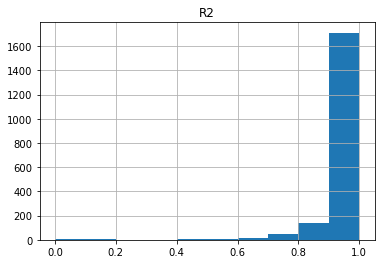

In [28]:
df_iso.hist(column='R2')

# Фильтруем набор данных

Из полученного датасета с обозначенными Ref кодами, оставляем только соединения где: 
- `Т = [273, 298] К`, 
- `g_inf <= 1000`

In [29]:
df_filt = df_fin.query("273 <= temperature <= 323 and R2 >= 0.95 and category != 'mod' and category != 'sim'")
df_filt.rename(columns={'Title': 'chemname', 'Label': 'refcode', 'Short Title': 'chemformula'}, inplace=True)
df_filt = df_filt[(df_filt['g_inf'] <= df_filt['g_inf'].quantile(q=0.99)) & (df_filt['K'] <= df_filt['K'].quantile(q=0.99))]
df_filt['min_delta_T_298'] = df_filt.groupby('adsorbent')['temperature'].transform(lambda s: s[np.abs(s - 298).idxmin()])
df_dataset = df_filt[df_filt['temperature'] == df_filt['min_delta_T_298']]
df_dataset

C:\ProgramData\Anaconda3\NewAnaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption,g_inf,K,R2,chemname,refcode,chemformula,min_delta_T_298
1,http://dx.doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2...",2.743010,0.048580,0.995877,NaN,NaN,NaN,298
2,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107...",1.801740,3.012629,0.984611,NaN,NaN,NaN,273
3,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33...",1.954641,2.058002,0.991906,NaN,NaN,NaN,273
4,http://dx.doi.org/10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4...",1.767504,2.060469,0.992460,NaN,NaN,NaN,273
5,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.0816749, 0.161957, 0.221112, 0.2...","[0.098115625, 0.31944375, 0.45777232142857144,...",1.592324,2.275958,0.988556,NaN,NaN,NaN,273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,http://dx.doi.org/10.1021/jp105464u,,MCM-41,Carbon Dioxide,298,bar,mmol/g,"[0.586854, 1.05634, 1.99531, 2.8169, 4.92958, ...","[0.298558, 0.675768, 0.942769, 1.28842, 1.7280...",5.071722,0.108041,0.992959,NaN,NaN,NaN,298
2881,http://dx.doi.org/10.1021/jp105464u,,MCM-41,Carbon Dioxide,298,bar,mmol/g,"[1.76056, 2.93427, 4.81221, 7.15962, 9.97653, ...","[0.596931, 0.800964, 1.06767, 1.34995, 1.60064...",3.956038,0.070144,0.986892,NaN,NaN,NaN,298
2882,http://dx.doi.org/10.1021/jp105464u,,MCM-41,Carbon Dioxide,298,bar,mmol/g,"[0.938967, 1.87793, 3.16901, 5.04695, 7.04225,...","[0.251277, 0.534001, 0.596488, 0.84747, 1.0826...",2.239523,0.119470,0.986929,NaN,NaN,NaN,298
2883,http://dx.doi.org/10.1021/jp105464u,,MCM-41,Carbon Dioxide,298,bar,mmol/g,"[0.821596, 1.99531, 3.16901, 5.04695, 6.80751,...","[0.078358, 0.140882, 0.187683, 0.312878, 0.406...",2.894251,0.022941,0.998881,NaN,NaN,NaN,298


# Убираем лишнее

In [30]:
df_dataset.rename(columns={'pressure': 'pressure(bar)', 'adsorption': 'adsorption(mmol/g)'}, inplace=True)
df_dataset.drop(['category', 'adsorbate', 'p_units','ads_units', 'min_delta_T_298'], axis=1, inplace=True)
df_dataset

C:\ProgramData\Anaconda3\NewAnaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\ProgramData\Anaconda3\NewAnaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,doi,adsorbent,temperature,pressure(bar),adsorption(mmol/g),g_inf,K,R2,chemname,refcode,chemformula
1,http://dx.doi.org/10.1002/adfm.201200084,NH2-MIL-53(Al),298,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2...",2.743010,0.048580,0.995877,NaN,NaN,NaN
2,http://dx.doi.org/10.1002/adfm.201300071,CCT1,273,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107...",1.801740,3.012629,0.984611,NaN,NaN,NaN
3,http://dx.doi.org/10.1002/adfm.201300071,CCT1,273,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33...",1.954641,2.058002,0.991906,NaN,NaN,NaN
4,http://dx.doi.org/10.1002/adfm.201300071,CT,273,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4...",1.767504,2.060469,0.992460,NaN,NaN,NaN
5,http://dx.doi.org/10.1002/adfm.201300071,CCT1,273,"[0.0112524, 0.0816749, 0.161957, 0.221112, 0.2...","[0.098115625, 0.31944375, 0.45777232142857144,...",1.592324,2.275958,0.988556,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2880,http://dx.doi.org/10.1021/jp105464u,MCM-41,298,"[0.586854, 1.05634, 1.99531, 2.8169, 4.92958, ...","[0.298558, 0.675768, 0.942769, 1.28842, 1.7280...",5.071722,0.108041,0.992959,NaN,NaN,NaN
2881,http://dx.doi.org/10.1021/jp105464u,MCM-41,298,"[1.76056, 2.93427, 4.81221, 7.15962, 9.97653, ...","[0.596931, 0.800964, 1.06767, 1.34995, 1.60064...",3.956038,0.070144,0.986892,NaN,NaN,NaN
2882,http://dx.doi.org/10.1021/jp105464u,MCM-41,298,"[0.938967, 1.87793, 3.16901, 5.04695, 7.04225,...","[0.251277, 0.534001, 0.596488, 0.84747, 1.0826...",2.239523,0.119470,0.986929,NaN,NaN,NaN
2883,http://dx.doi.org/10.1021/jp105464u,MCM-41,298,"[0.821596, 1.99531, 3.16901, 5.04695, 6.80751,...","[0.078358, 0.140882, 0.187683, 0.312878, 0.406...",2.894251,0.022941,0.998881,NaN,NaN,NaN


# Добавляем еще refcode 

In [31]:
search6 = pd.read_excel("search6.xlsx")

In [32]:
df_output = pd.merge(df_dataset, search6, on='adsorbent', how='left')
df_output.to_excel("MOF_CO2_uptake_filtered_dataset.xlsx")

# Построение графиков изотерм выбранного MOF из датасета

In [ ]:
df_set_drpdwn = widgets.Dropdown(
    options=list(df_set.drop_duplicates(subset=['adsorbent'])['adsorbent']),
    description='MOF:',
    disabled=False,
)
df_set_drpdwn

In [ ]:
subset = df_set[df_set['adsorbent']== df_set_drpdwn.value]
subset

In [ ]:
subset_drpdwn = widgets.Dropdown(
    options=subset.index.values.tolist(),
    description='Choose',
    disabled=False,
)
subset_drpdwn

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
mof_ind = subset_drpdwn.value
plt.subplot(121)
plt.plot(df_set.loc[mof_ind, 'pressure'], 1000*np.array(df_set.loc[mof_ind, 'adsorption']), 'ro--')
plt.title(df_set.loc[mof_ind, 'adsorbent'])
plt.ylabel(df_set.loc[mof_ind, 'doi'])
plt.subplot(122)
plt.plot(df_set.loc[mof_ind, 'pressure'], df_set.loc[mof_ind, 'adsorption'], 'bo--')
plt.title(df_set.loc[mof_ind, 'adsorbent'])
plt.show()